In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.3.0
probtorch: 0.0+5a2c637 torch: 1.3.0 cuda: True


In [3]:
%run PARAMETERS.py
NAME = 'VAE'
PATH = NAME + '-%dpts-%dsamples' % (N, SAMPLE_SIZE)
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')

ANGLE = np.load(data_path + '/angle.npy')
ANGLE = np.where(ANGLE<0, 2*math.pi + ANGLE, ANGLE % (2*math.pi))
ANGLE = torch.from_numpy(ANGLE).float()
STATE = torch.from_numpy(np.load(data_path + '/state.npy')).float()
NUM_DATASETS = data.shape[0]
NUM_BATCHES = int((NUM_DATASETS / BATCH_SIZE))

FileNotFoundError: [Errno 2] No such file or directory: '/home/hao/Research/apg_data/ncmm/squares_192/ob.npy'

NameError: name 'SAMPLE_SIZE' is not defined

In [3]:
from decoder import *
from global_enc_mu_v2 import *
dec_x = Dec_x(K, D, NUM_HIDDEN_DEC, RECON_SIGMA, CUDA, DEVICE)
# f_angle = Enc_angle(D, NUM_HIDDEN_ANGLE, CUDA, DEVICE)
# f_state = Enc_state(K, D, NUM_HIDDEN_STATE, CUDA, DEVICE)
f_mu = Enc_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_NSS, CUDA, DEVICE)
if CUDA:
    with torch.cuda.device(DEVICE):
        dec_x.cuda()
#         f_angle.cuda()
        f_mu.cuda()
#         f_state.cuda()
optimizer =  torch.optim.Adam(list(f_mu.parameters())+list(dec_x.parameters()),lr=1e-3, betas=(0.9, 0.99))

In [4]:
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    LOSS = 0.0
    indices = torch.randperm(NUM_DATASETS)
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        ob = data[batch_indices]
        state = STATE[batch_indices]
        angle = ANGLE[batch_indices]
        ob_embed = torch.cat((ob, angle, state), -1)
        ob_embed = shuffler(ob_embed).repeat(SAMPLE_SIZE, 1, 1, 1) 
        if CUDA:
            with torch.cuda.device(DEVICE):
                ob_embed =ob_embed.cuda()
        ob = ob_embed[:, :, :, :2]
        angle = ob_embed[:, :, :, 2].unsqueeze(-1) 
        state = ob_embed[:,:,:, 3:]
        q_f_mu, p_f_mu = f_mu(ob, state, angle)
        mu = q_f_mu['means'].value
        log_p_f_mu = p_f_mu['means'].log_prob.sum(-1)
        log_q_f_mu = q_f_mu['means'].log_prob.sum(-1)        
    
        p = dec_x(ob, state, angle, mu)
#         ll = p['likelihood'].log_prob.sum(-1) ## S * B * N
        ll = torch.cat([((state.argmax(-1)==k).float() * (p['likelihood'].log_prob.sum(-1))).sum(-1).unsqueeze(-1) for k in range(K)], -1) # S * B * K
        log_w =  ll.detach() + log_p_f_mu - log_q_f_mu
        w = F.softmax(log_w, 0).detach()
        loss_phi = (w * log_w).sum(0).sum(-1).mean()
        loss_theta = (- w * ll).sum(0).sum(-1).mean()
        ## gradient step
        loss_phi.backward(retain_graph=True)
        loss_theta.backward()
        optimizer.step()  
        LOSS += loss_theta.detach()
    if epoch % 1 == 0:
        time_end = time.time()
        print('epoch=%d, loss=%.4f (%ds)' % (epoch, LOSS / NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, loss=5984.4365 (12s)
epoch=1, loss=206.4347 (12s)
epoch=2, loss=11.8091 (13s)
epoch=3, loss=-47.9448 (12s)
epoch=4, loss=-81.5629 (8s)
epoch=5, loss=-102.3157 (7s)
epoch=6, loss=-117.9649 (9s)
epoch=7, loss=-128.9288 (10s)
epoch=8, loss=-137.4179 (10s)
epoch=9, loss=-143.9822 (10s)
epoch=10, loss=-150.9113 (10s)
epoch=11, loss=-156.8886 (10s)
epoch=12, loss=-163.1025 (10s)
epoch=13, loss=-168.3962 (10s)
epoch=14, loss=-173.2127 (10s)
epoch=15, loss=-177.1197 (9s)
epoch=16, loss=-180.4944 (10s)
epoch=17, loss=-183.6576 (10s)
epoch=18, loss=-186.2135 (10s)
epoch=19, loss=-189.3738 (10s)
epoch=20, loss=-191.8824 (12s)
epoch=21, loss=-194.2631 (11s)


KeyboardInterrupt: 

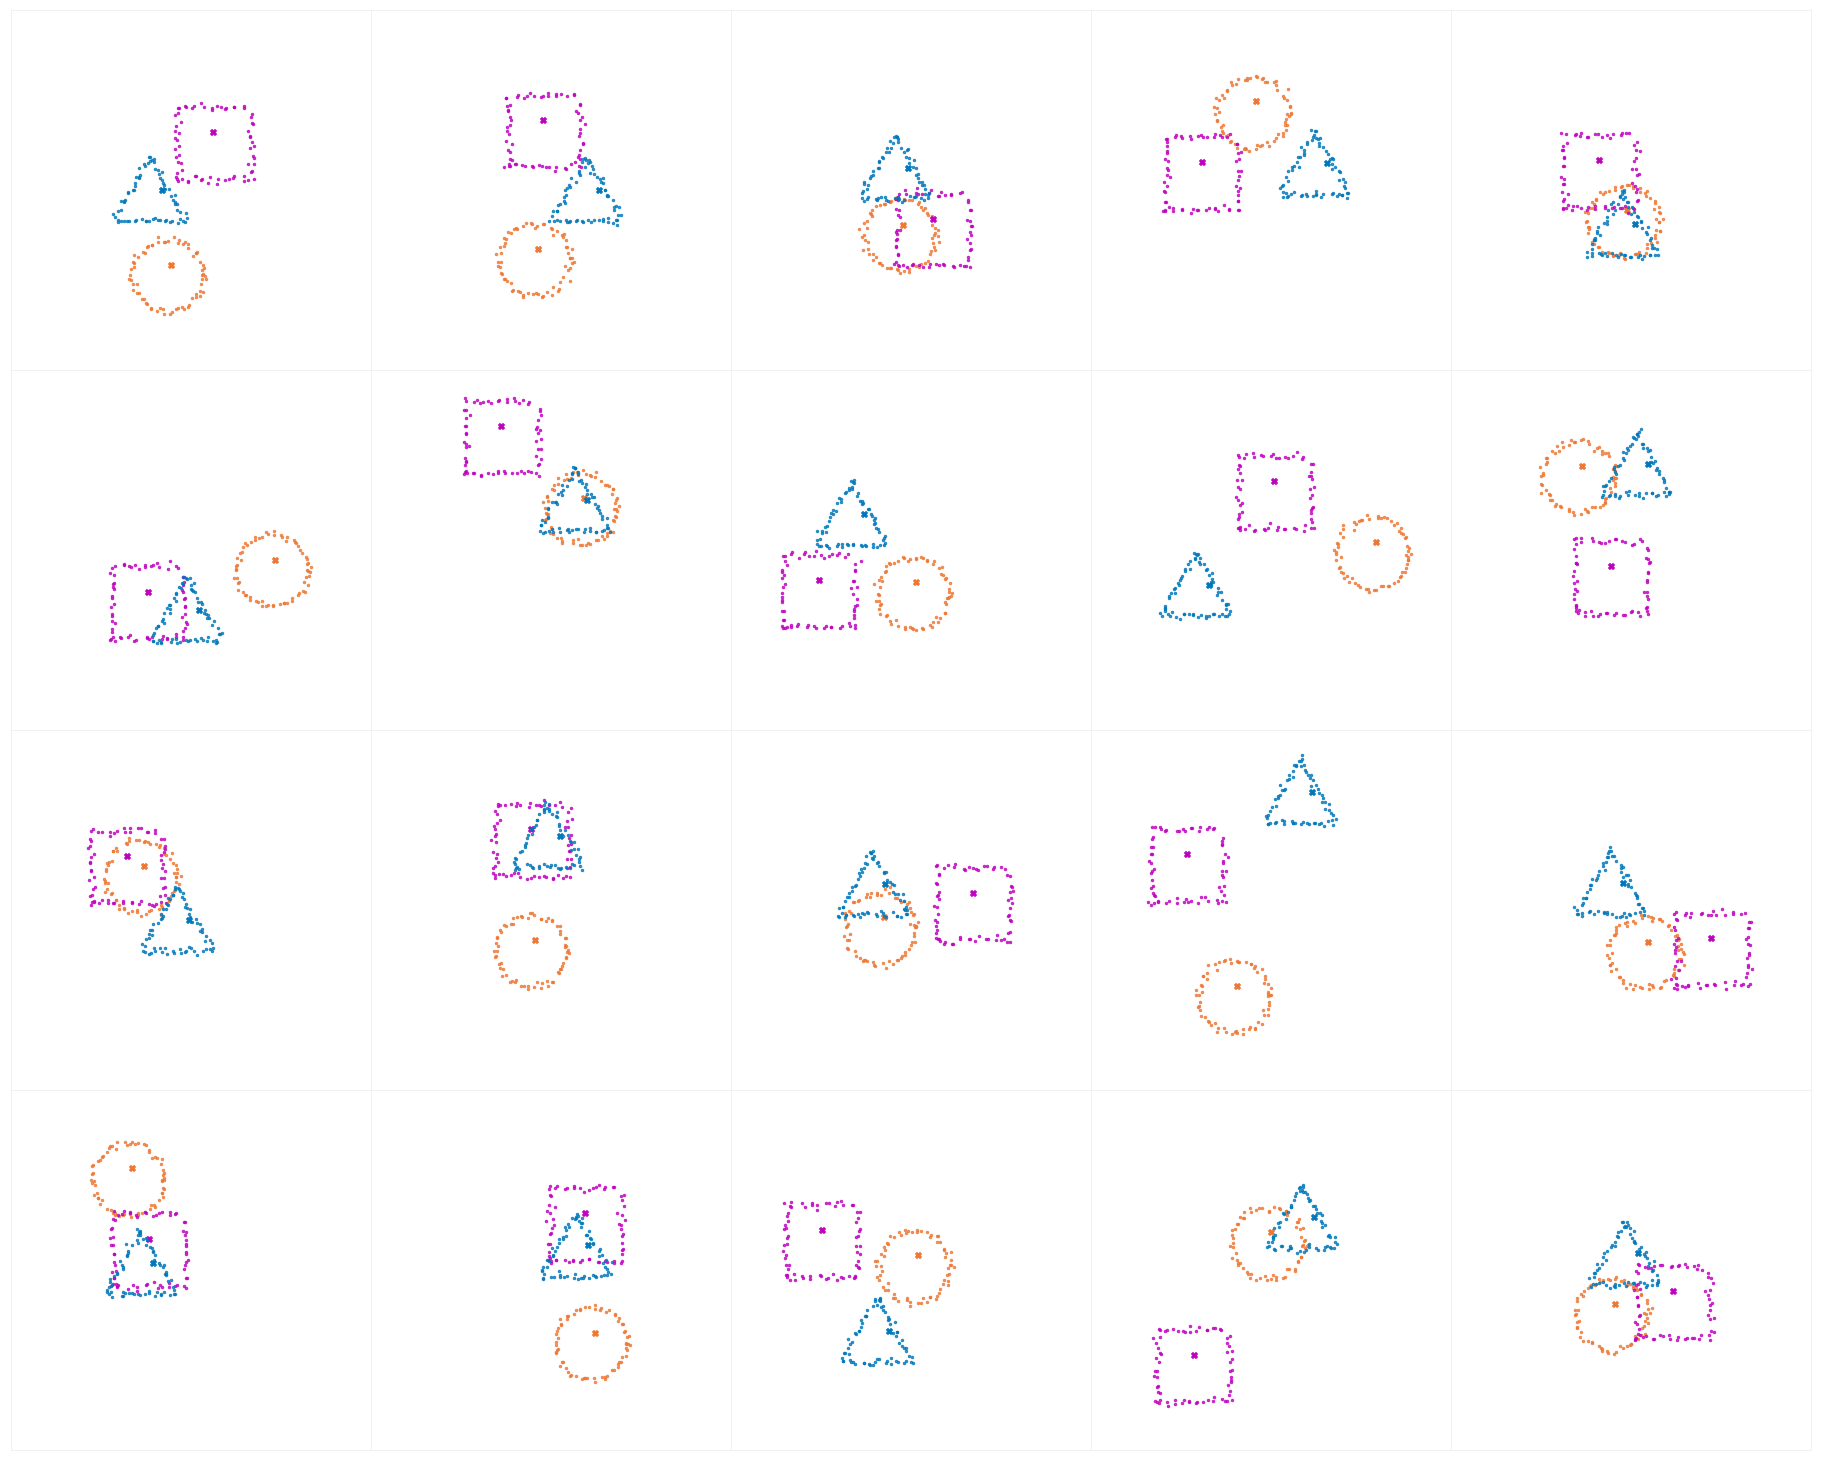

In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from plots import plot_final_samples
    
indices = torch.randperm(NUM_DATASETS)
batch_indices = indices[0*BATCH_SIZE : (0+1)*BATCH_SIZE]
ob = data[batch_indices]
state = STATE[batch_indices]
angle = ANGLE[batch_indices]
ob_embed = torch.cat((ob, angle, state), -1)
ob_embed = shuffler(ob_embed).repeat(SAMPLE_SIZE, 1, 1, 1) 
if CUDA:
    with torch.cuda.device(DEVICE):
        ob_embed =ob_embed.cuda()
ob = ob_embed[:, :, :, :2]
angle = ob_embed[:, :, :, 2].unsqueeze(-1)
state = ob_embed[:,:,:, 3:]
# E_mu = ss_to_stats(ob, state)
q_f_mu, _ = f_mu(ob, state, angle)
mu = q_f_mu['means'].value
log_p_f_mu = p_f_mu['means'].log_prob.sum(-1)
log_q_f_mu = q_f_mu['means'].log_prob.sum(-1)    
p = dec_x(ob, state, angle, mu)
E_mu = q_f_mu['means'].dist.loc
recon_mu = p['likelihood'].dist.loc[0].cpu().data.numpy()
# plot_final_samples(recon_mu, mu[0].cpu().data.numpy(), state[0].cpu().data.numpy(), K, PATH)
plot_final_samples(ob[0].cpu().data.numpy(), E_mu[0].cpu().data.numpy(), state[0].cpu().data.numpy(), K, PATH)

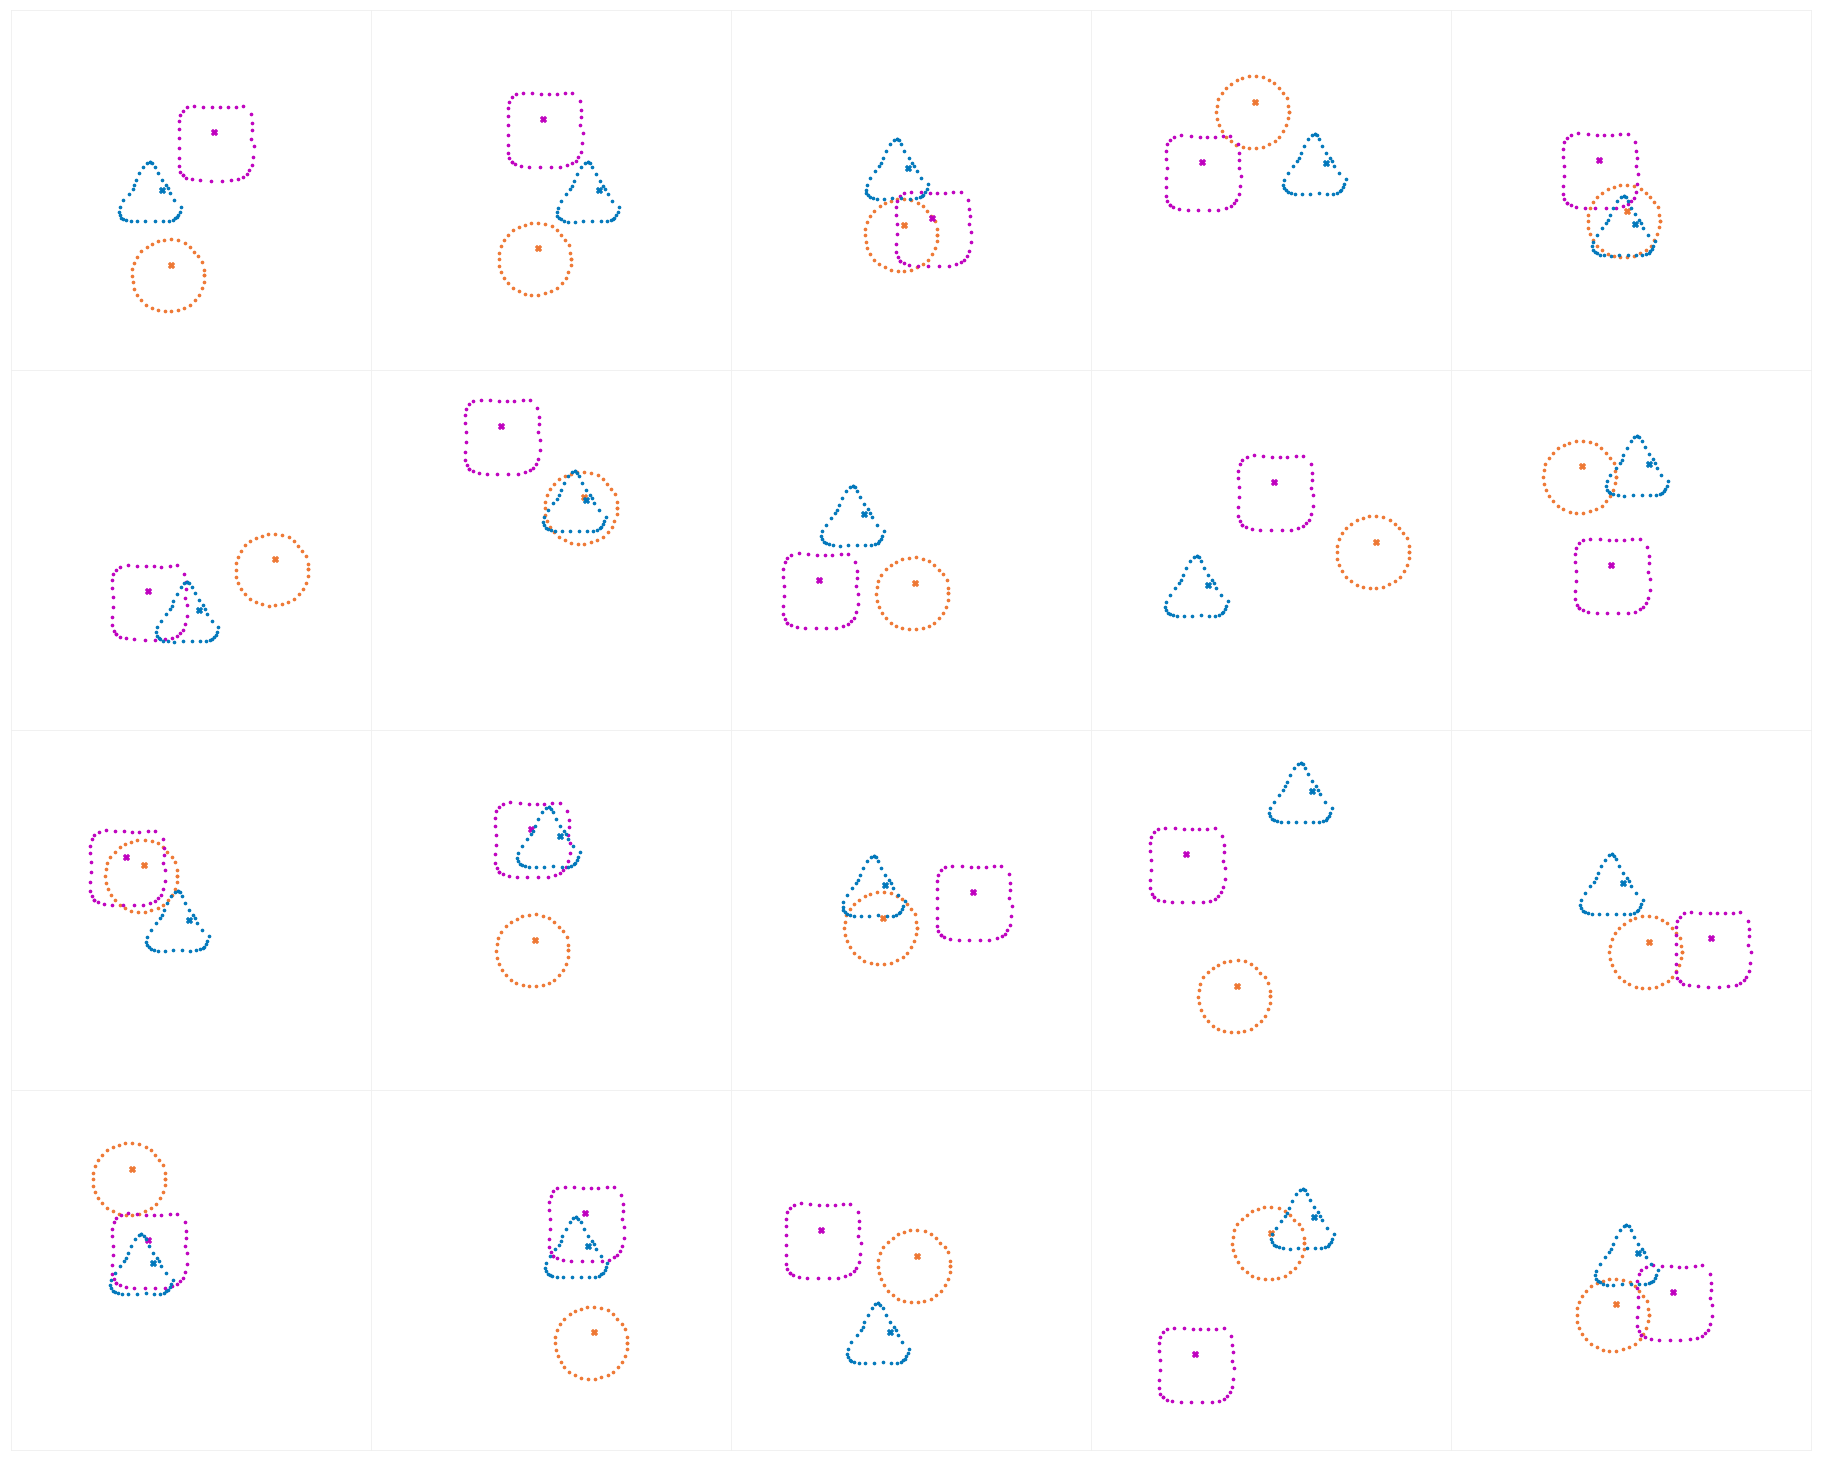

In [6]:
plot_final_samples(recon_mu, mu[0].cpu().data.numpy(), state[0].cpu().data.numpy(), K, PATH)


In [ ]:
t = angle[0,0].cpu().data.numpy()
plt.plot(t)

In [ ]:
tt= np.where(t<0, 2*math.pi + t, t % (2*math.pi))

In [ ]:
plt.plot(tt)